In [1]:
import sys
sys.path.insert(0, '../../../Utilities/')
import argparse
import os
import torch
from collections import OrderedDict
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import seaborn as sns
import pylab as py
import time
from pyDOE import lhs
import warnings
sys.path.insert(0, '../../../Scripts/')
from models_pde import Net
from pinn import *
# from ../Scripts/helper import *

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [3]:
num_epochs = 30000
lambda_phy = 1

noise = 0.0

## Network Architecture
hid_dim = 20
num_layer = 8

## Load Data

In [4]:
N_u = 50
N_i = 100
N_f = 10000
data = scipy.io.loadmat('../../../datasets/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

print(t.shape)
print(x.shape)
print(Exact.shape)


X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None] 

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

# initial conditions t = 0
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# boundary conditions x = lb
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# boundary conditions, x = ub
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx2, xx3]) 
u_train = np.vstack([uu2, uu3])

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack([X_f_train, X_u_train, xx1])

# selecting N_u boundary points for training
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

# selecting N_i initial points for training
idx = np.random.choice(xx1.shape[0], N_i, replace=False)
X_i_train = xx1[idx, :]
u_i_train = uu1[idx, :]

# adding boundary and initial points
X_u_train = np.vstack([X_u_train, X_i_train])
u_train = np.vstack([u_train, u_i_train])

(100, 1)
(256, 1)
(100, 256)


## Model

In [5]:
net = Net(in_dim = 2, out_dim = 1, hid_dim = hid_dim, num_layers = num_layer).to(device)

In [6]:
burgers = Burgers_PINN(X_u_train, u_train, X_f_train, X_star, u_star, net, device, num_epochs, lambda_phy, noise)

In [7]:
burgers.train()

[Epoch 0/30000] [MSE loss: 0.426030] [Phy loss: 0.000044] [Total loss: 0.426074]


[Epoch 100/30000] [MSE loss: 0.342025] [Phy loss: 0.000021] [Total loss: 0.342046]
[Epoch 200/30000] [MSE loss: 0.257373] [Phy loss: 0.001650] [Total loss: 0.259023]
[Epoch 300/30000] [MSE loss: 0.185178] [Phy loss: 0.011922] [Total loss: 0.197100]
[Epoch 400/30000] [MSE loss: 0.167072] [Phy loss: 0.011269] [Total loss: 0.178341]
[Epoch 500/30000] [MSE loss: 0.154323] [Phy loss: 0.012205] [Total loss: 0.166528]
[Epoch 600/30000] [MSE loss: 0.147569] [Phy loss: 0.013772] [Total loss: 0.161341]
[Epoch 700/30000] [MSE loss: 0.141966] [Phy loss: 0.014840] [Total loss: 0.156806]
[Epoch 800/30000] [MSE loss: 0.131547] [Phy loss: 0.016667] [Total loss: 0.148214]
[Epoch 900/30000] [MSE loss: 0.115710] [Phy loss: 0.020583] [Total loss: 0.136293]
[Epoch 1000/30000] [MSE loss: 0.097012] [Phy loss: 0.026131] [Total loss: 0.123143]
[Epoch 1100/30000] [MSE loss: 0.082258] [Phy loss: 0.029857] [Total loss: 0.112115]
[Epoch 1200/30000] [MSE loss: 0.070937] [Phy loss: 0.030127] [Total loss: 0.101064]
[

In [8]:
Xmean = burgers.Xmean
Xstd = burgers.Xstd
X_star_norm = (X_star - Xmean) / Xstd

u_pred_list = []
f_pred_list = []

for run in range(500):
    u_pred, f_pred = burgers.get_residual(X_star_norm)
    u_pred_list.append(u_pred.detach().cpu().numpy())
    f_pred_list.append(f_pred.detach().cpu().numpy())

u_pred_arr = np.array(u_pred_list)
f_pred_arr = np.array(f_pred_list)
u_pred = u_pred_arr.mean(axis=0)
f_pred = f_pred_arr.mean(axis=0)
u_dev = u_pred_arr.var(axis=0)
f_dev = f_pred_arr.var(axis=0)

In [9]:
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     
print('Residual: %e' % (f_pred**2).mean())
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
U_dev = griddata(X_star, u_dev.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 3.421133e-02
Residual: 1.967923e-04


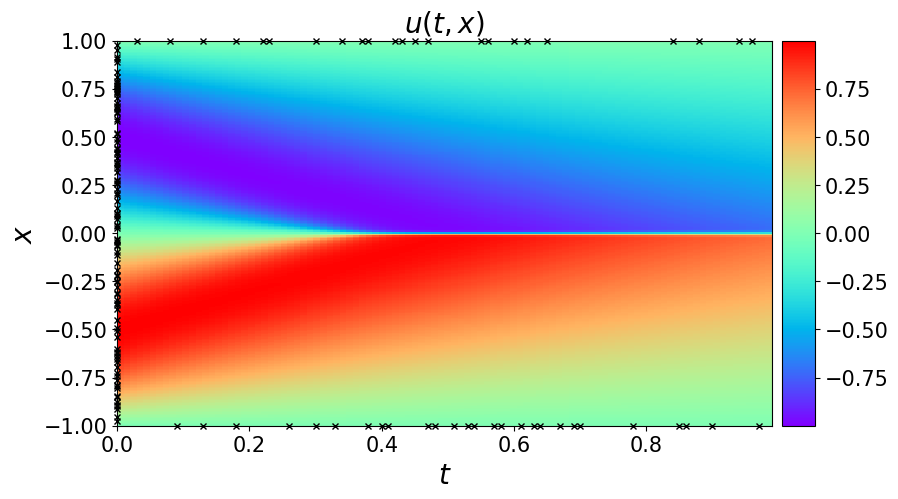

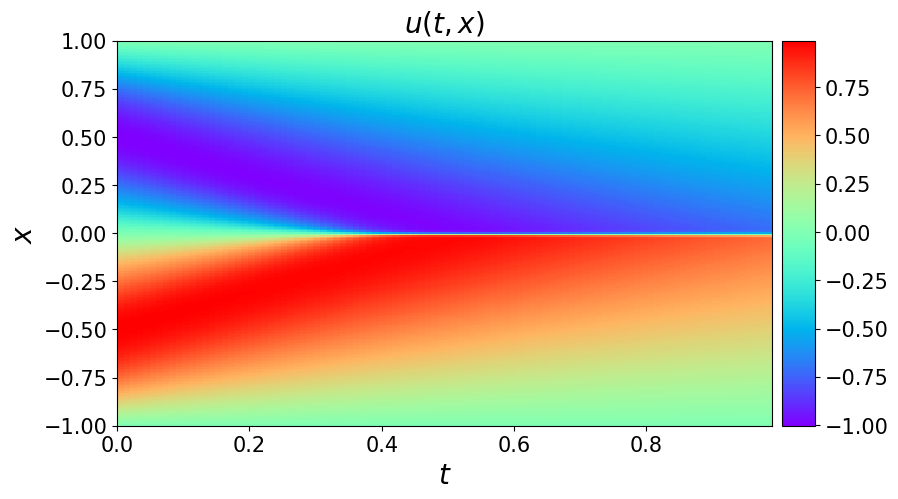

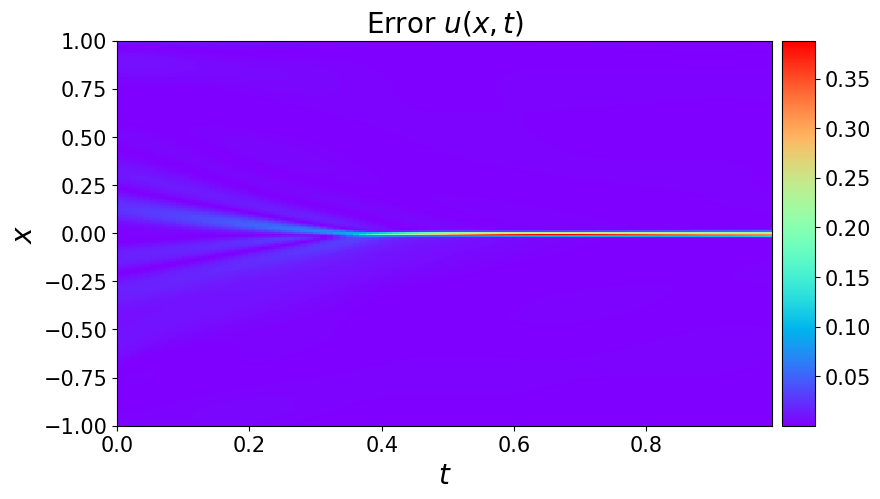

In [10]:
""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    
X_u_train_ = X_u_train
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

h = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train_[:,1], 
    X_u_train_[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
# ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

# ax.plot(
#     X_u_train_[:,1], 
#     X_u_train_[:,0], 
#     'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# )


ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

h = ax.imshow(Error.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto',vmax = np.amax(Error.T),
              vmin = np.amin(Error.T))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

# ax.plot(
#     X_u_train_[:,1], 
#     X_u_train_[:,0], 
#     'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# )

# line = np.linspace(x.min(), x.max(), 2)[:,None]
# ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
# ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.set_title('Error $u(x,t)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

In [11]:
print('Max is :',np.amax(Error.T))
print('Min is :',np.amin(Error.T))

Max is : 0.3881331222863435
Min is : 1.309645063507503e-07


Text(0.5, 1.0, '$t = 0.75$')

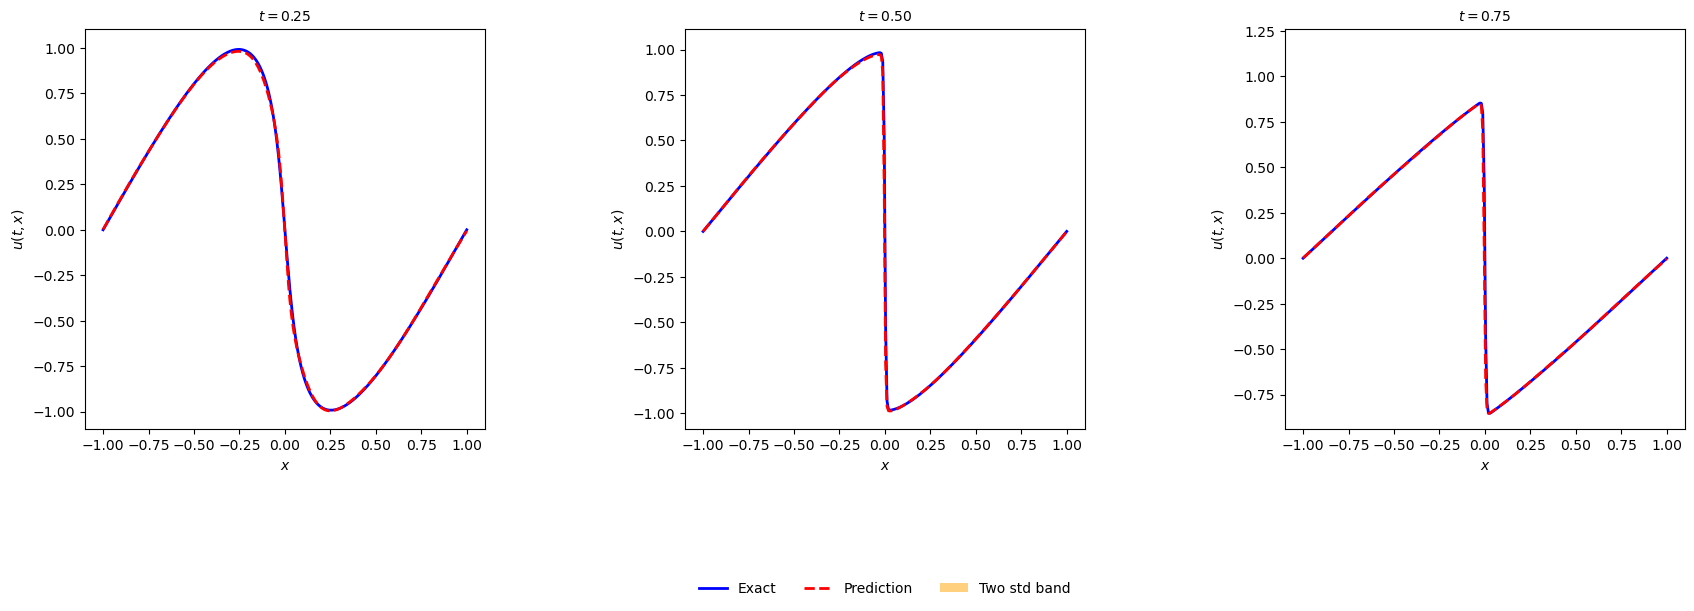

In [12]:
####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
lower = U_pred[25,:] - 2.0*np.sqrt(U_dev[25,:])
upper = U_pred[25,:] + 2.0*np.sqrt(U_dev[25,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
# ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
lower = U_pred[50,:] - 2.0*np.sqrt(U_dev[50,:])
upper = U_pred[50,:] + 2.0*np.sqrt(U_dev[50,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
# ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
lower = U_pred[75,:] - 2.0*np.sqrt(U_dev[75,:])
upper = U_pred[75,:] + 2.0*np.sqrt(U_dev[75,:])
plt.fill_between(x.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
# ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

# fig, ax = newfig(1.0)
# ax.axis('off')

In [13]:
st = 0.30
tt = int(t.shape[0] * st)


In [14]:
tt_error

NameError: name 'tt_error' is not defined

In [ ]:
np.savetxt('PINN_result.txt',np.reshape(U_pred[tt,:],(256,1)),fmt = '%f')

tt_error = np.sum(Error[tt,:])
np.savetxt('PINN_ERROR.txt',[tt_error],fmt = '%f')


In [ ]:
b = np.loadtxt('PINN_result.txt',dtype=float)